# Baseline Sentiment Analysis
Sentiment analysis of Indonesian online marketplace app reviews.

Steps:
1. EDA and data cleaning
2. Baseline model using traditional machine learning

## Loading Dependencies

In [2]:
import re

import pandas as pd

# Visualization
import seaborn as sns

# Google cloud
from google.oauth2 import service_account
from google.cloud import bigquery

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

2022-01-08 03:02:41.496314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-08 03:02:41.496366: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
key_path = '../airflow/credentials/future-data-track-1-sapporo.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bigquery_client = bigquery.Client(
    project='future-data-track-1',
    credentials=credentials
)

In [4]:
query = """
WITH t AS (
  SELECT *
  FROM `future-data-track-1.sapporo_mart.sentiment_analysis`
),
table_stats AS (
  SELECT *, SUM(c) OVER() total 
  FROM (
    SELECT sentiment, COUNT(*) c 
    FROM t
    GROUP BY 1 
    HAVING c>100000)
)
SELECT sample.*
FROM (
SELECT ARRAY_AGG(a ORDER BY RAND() LIMIT 40000) cat_samples, sentiment, ANY_VALUE(c) c
FROM t a
JOIN table_stats b
USING(sentiment)
WHERE sentiment != 1
GROUP BY sentiment
), UNNEST(cat_samples) sample WITH OFFSET off;
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()

In [5]:
df.head()

,review,rating,sentiment
0,Ok,5,2
1,Sangat membantu untuk meningkatkan penjualan,5,2
2,"Barang bagus,Murmer byk diskon,kurir ramah,pen...",5,2
3,Aplikasi bagus,5,2
4,Aplikasi recommend,5,2


## 1. EDA and cleaning

<AxesSubplot:xlabel='sentiment', ylabel='count'>

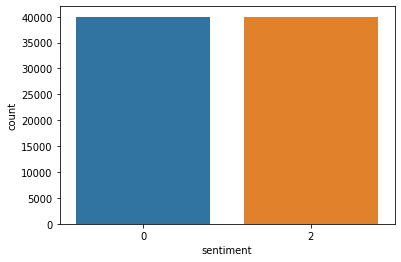

In [6]:
sns.countplot(df["sentiment"])

In [7]:
df.isna().sum()

review       2
rating       0
sentiment    0
dtype: int64

In [8]:
df = df.dropna(axis=0)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79998 entries, 0 to 79999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     79998 non-null  object
 1   rating     79998 non-null  int64 
 2   sentiment  79998 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.4+ MB


### Cleaning

In [10]:
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    texts = texts.lower()

    return texts

In [11]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

In [12]:
df.head()

,review,rating,sentiment,review_cleaned
0,Ok,5,2,ok
1,Sangat membantu untuk meningkatkan penjualan,5,2,sangat membantu untuk meningkatkan penjualan
2,"Barang bagus,Murmer byk diskon,kurir ramah,pen...",5,2,barang bagus murmer byk diskon kurir ramah pen...
3,Aplikasi bagus,5,2,aplikasi bagus
4,Aplikasi recommend,5,2,aplikasi recommend


In [13]:
word_length = []
for row in df['review_cleaned']:
    word_length.append(len(row))

display(pd.DataFrame(word_length, columns=['word_length']).describe())
display(pd.DataFrame(word_length, columns=['word_length']).quantile(0.90))

,word_length
count,79998.000000
mean,68.948636
std,88.113561
min,1.000000
25%,12.000000
50%,35.000000
75%,90.000000
max,1232.000000


word_length    178.0
Name: 0.9, dtype: float64

In [14]:
df['sentiment'] = df['sentiment'].map({0:0, 2:1})

## 2. Baseline model

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      9834
           1       0.88      0.90      0.89     10166

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



<AxesSubplot:>

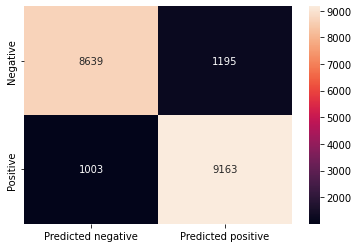

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'])
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr_clf', LogisticRegression())])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])